In [7]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import sem

from cpsplines.mosek_functions.interval_constraints import IntConstraints
from cpsplines.psplines.bspline_basis import BsplineBasis
from cpsplines.psplines.penalty_matrix import PenaltyMatrix
from cpsplines.fittings.fit_cpsplines import CPsplines
from cpsplines.utils.gcv import GCV
import statsmodels.genmod.families.family
import mosek.fusion as mf

from Functions import poly

from Functions import simpleGCV
from Functions import choose_lambda
from Functions import simpson_spline_full
from Functions import simpson_spline_matrices
from Functions import intGCV
from Functions import choose_lambda_int
from Functions import create_obj_mat
from Functions import unconstrained_sof_fit
from Functions import cp_sof_fit
import time
from scipy.stats import norm
from scipy import special

In [ ]:
#ESTO PARA NUESTRO PROBLEMA
rankX = 20
alpha = 0.15
#Trabajaremos con estos datos
m = 50
T = np.linspace(0.0, 0.8, num=m)
Phi = np.append(np.tile(1/np.sqrt(m), (m, 1)), poly(T, degree=rankX-1)[0], axis = 1)
lambda1_ = np.arange(rankX, 0, -1)


T2 = np.linspace(0.0, 0.8, num=501)
betaT =0.2* norm.pdf(T, loc=1, scale=0.2)
betaT2=0.2*norm.pdf(T2, loc=1, scale=0.2)
#betaT = 1/special.erf(T)*0.01
#betaT2 = 1/special.erf(T2)*0.01
# betaT = np.exp(-T**2)
# betaT2 = np.exp(-T2**2)

# betaT = 0.1*((2*T)**2+1/4-(2*T))
# betaT2 = 0.1*((2*T2)**2+1/4-2*T2)
# betaT = beta(T)
#weights. 1/3 for the limits, 2/3 for the odd subintervals, 4/3 for the even ones. 

w = [1/3] + [4/3 if i%2==0 else 2/3 for i in range(2,501)] + [1/3]
W = 1/501* np.diag(w)
plt.plot(T,betaT, 'k-')


In [ ]:
betaT=pd.read_csv("betaT_norm2.csv", header=None )
betaT=np.array(betaT).squeeze()
betaT2=pd.read_csv("betaT2_norm2.csv", header=None )
betaT2=np.array(betaT2).squeeze()

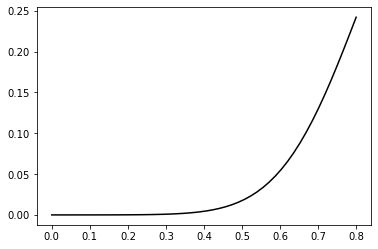

In [9]:
plt.plot(T,betaT, 'k-')

In [4]:
#Trabajaremos con estos datos
N=200
normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
eps = np.random.normal(0, 0.01, N)
Xi=[]
for j in range(rankX):
    z=normalfunc(lambda1_[j])
    Xi.append(z-z.mean())
X = np.dot(np.transpose(Xi), np.transpose(Phi))
lfterm = np.dot((1/m)*X, betaT)

y = alpha + lfterm + eps


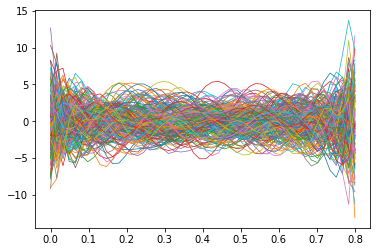

In [5]:
# He simplidicado las X

#Gráfico de las X
# Plot all rows of X against T
for i in range(X.shape[0]):
    plt.plot(T, X[i,:], linewidth=0.75)

## ERROR SIGUE UNA $N(0, 0.01)$

### Gráficos

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


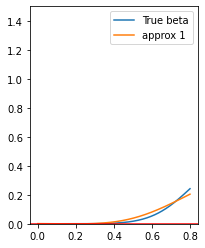

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


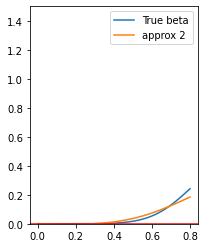

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


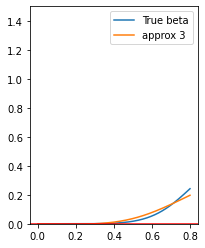

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


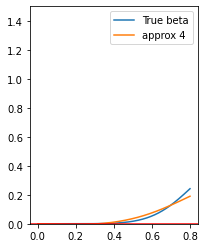

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


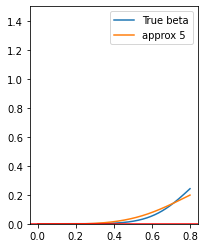

IMSE for N= 125 0.21775020888375177
MSE for N= 125 0.308914309154489
Standard deviation of the IMSE: 6.630548691394836e-06
Standard deviation of the MSE: 1.145794232548392e-05


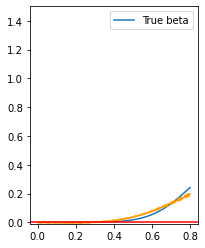

In [122]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 5

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

IMSE=np.zeros(n_sims)
MSE=np.zeros(n_sims)

for N in [125]:
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_normdec001', str(i+1), str(N)])
        tttt="_".join(['y_normdec001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        plt.figure(figsize=(3,4))
        plt.plot(T2, betaT2, label = 'True beta')
        plt.plot(T2,betagorro, label=f'approx {i+1}')
        plt.axhline(0, color='red')
        plt.ylim([0, 1.5])
        plt.legend()
        plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
        #IMSE
        IMSE[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE))
    print('Standard deviation of the MSE:', sem(MSE))
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([-0.01, 1.5])
plt.legend()
plt.show()

### Cálculo del IMSE y del MSE

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


IMSE for N= 35 0.8091263304934251
MSE for N= 35 0.1635826658347241
Standard deviation of the IMSE: 9.278694414788539e-05
Standard deviation of the MSE: 7.709375790054612e-06
IMSE for N= 75 0.8703621246704432
MSE for N= 75 0.1983909974983529
Standard deviation of the IMSE: 5.8958845346316304e-05
Standard deviation of the MSE: 8.065805095407821e-06
IMSE for N= 125 0.20314340921240773
MSE for N= 125 0.28866580449284307
Standard deviation of the IMSE: 5.445416076638494e-06
Standard deviation of the MSE: 2.5887689427353477e-06


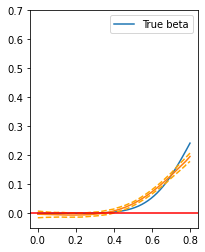

Times [116.28280592 197.61400962 291.5934217 ]


In [10]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_uncons=np.zeros(n_sims)
MSE_uncons=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_normdec001', str(i+1), str(N)])
        tttt="_".join(['y_normdec001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_uncons[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_uncons[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=',N,  IMSE_uncons.sum()/n_sims*1000)
    print('MSE for N=',N,  MSE_uncons.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_uncons))
    print('Standard deviation of the MSE:', sem(MSE_uncons))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([-0.05, 0.7])
plt.legend()
plt.show()
print('Times', time_unconstrained)

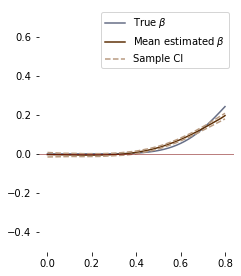

In [6]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([-0.5, 0.75])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('normalcreciente_unconstrained.png', transparent=True)
plt.show()

In [ ]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([-0.5, 0.75])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('aaaaaaaa.png', transparent=True)
plt.show()

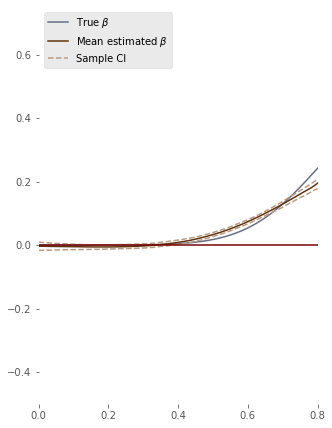

In [15]:
plt.figure(figsize=(5,7.3))
plt.plot(T2, betaT2        , label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci   , linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci   , linestyle='dashed', color='#B99B81')
plt.axhline(0, color='#780000')
# Plot a horizontal line at y=0
plt.ylim([-0.5, 0.75])
plt.xlim([0, 0.8])
plt.xticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8])
plt.legend(loc='upper left')
plt.style.use('ggplot')
plt.box(False)
plt.savefig('siu.png', transparent=True)
plt.show()

## CONSTRAINED: ERROR SIGUE UNA $N(0, 0.01)$

### Plots

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


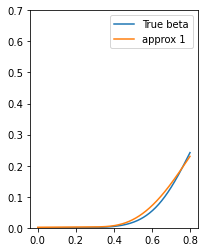

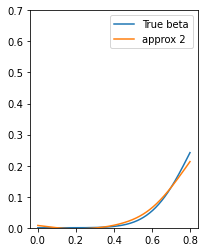

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


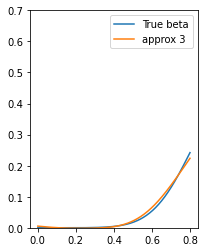

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


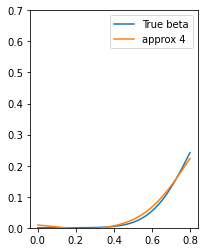

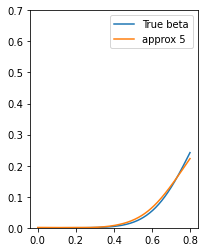

IMSE for N= 125 0.05116478352608161
MSE for N= 125 0.2581206589753644
Standard deviation of the IMSE: 6.7340517936220385e-06
Standard deviation of the MSE: 1.4603580397194065e-05


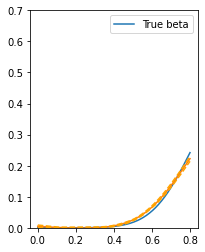

Times [7.43130279 0.         0.        ]


In [112]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 5

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE=np.zeros(n_sims)
MSE=np.zeros(n_sims)

cont=0
for N in [125]:
    start_time = time.time()
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_normdec001', str(i+1), str(N)])
        tttt="_".join(['y_normdec001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=2, sign='+', sign_threshold=0.0,  plot=False)
        plt.figure(figsize=(3,4))
        plt.plot(T2, betaT2, label = 'True beta')
        plt.plot(T2,betagorro, label=f'approx {i+1}')
        plt.axhline(0, color='red', linewidth=0.5)
        plt.ylim([0.0, 0.7])
        plt.legend()
        plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE))
    print('Standard deviation of the MSE:', sem(MSE))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([0, 0.7])
plt.legend()
plt.show()
print('Times', time_unconstrained)

### Cálculo del IMSE y del MSE

In [ ]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_cons=np.zeros(n_sims)
MSE_cons=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        eps = np.random.normal(0, 0.01, N)
    
        Xi=[]
        for j in range(rankX):
            z=normalfunc(lambda1_[j])
            Xi.append(z-z.mean())
        X = np.dot(np.transpose(Xi), np.transpose(Phi)) 
        
        lfterm = np.dot((1/m)*X, betaT)
        
        y = alpha + lfterm + eps
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=1, sign='+', sign_threshold=0.0,  plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_cons[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_cons[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE_cons.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE_cons.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE))
    print('Standard deviation of the MSE:', sem(MSE))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([-0.1, 0.3])
plt.legend()
plt.show()
print('Times', time_unconstrained)

c:\Users\Diego\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


IMSE for N= 125 0.04783061130379516
MSE for N= 125 0.24733606066147473
Standard deviation of the IMSE: 1.5658900988469957e-06
Standard deviation of the MSE: 2.075761836363488e-06


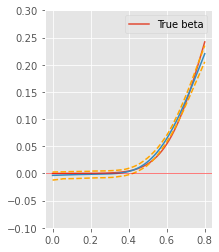

Times [308.13758945   0.           0.        ]


In [16]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_cons=np.zeros(n_sims)
MSE_cons=np.zeros(n_sims)

cont=0
for N in [125]:
    start_time = time.time()
    normalfunc = lambda l: np.random.normal(scale=math.sqrt(l), size=N)
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X_normdec001', str(i+1), str(N)])
        tttt="_".join(['y_normdec001', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=1, sign='+', sign_threshold=0.0,  plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_cons[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_cons[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=', N,  IMSE_cons.sum()/n_sims*1000)
    print('MSE for N=', N,  MSE_cons.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_cons))
    print('Standard deviation of the MSE:', sem(MSE_cons))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red', linewidth=0.5)
plt.ylim([-0.1, 0.3])
plt.legend()
plt.show()
print('Times', time_unconstrained)

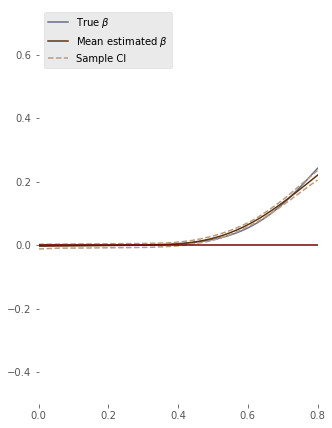

In [17]:
plt.figure(figsize=(5,7.3))
plt.plot(T2, betaT2        , label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci   , linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci   , linestyle='dashed', color='#B99B81')
plt.axhline(0, color='#780000')
# Plot a horizontal line at y=0
plt.ylim([-0.5, 0.75])
plt.xlim([0, 0.8])
plt.xticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8])
plt.legend(loc='upper left')
plt.style.use('ggplot')
plt.box(False)
plt.savefig('siuuu.png', transparent=True)
plt.show()

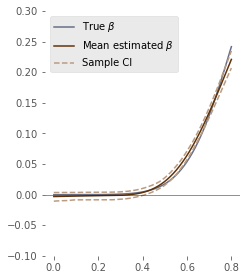

In [ ]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([-0.5, 0.75])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('normalcrecienteconstrained.png', transparent=True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Generate random data
np.random.seed(1)


# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Customize boxplot colors
box_colors = ['#BC9874', '#9899B5', '#BC9874', '#9899B5']
box_labels = ['U-Psplines', 'C-Psplines', 'U-Bernstein', 'C-Bernstein']
legend_labels = ['Unconstrained', 'Constrained']
# Create boxplot
boxplot = ax.boxplot([IMSE_cons*1000, IMSE_uncons*1000, imse_uncons_pareto_nonneg_ellos*1000, imse_cons_pareto_nonneg_ellos,], patch_artist=True, widths=0.5)

# Set boxplot style
for patch, color in zip(boxplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set whisker and cap style
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='#757575', linewidth=1.5, linestyle='--')
    cap.set(color='#757575', linewidth=1.5)

# Set median line style
for median in boxplot['medians']:
    median.set(color='#FF5252', linewidth=1)

# Set outliers style
for flier in boxplot['fliers']:
    flier.set(marker='o', markersize=5, markerfacecolor='#FF5252', alpha=0.8)

# Create custom legend
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(box_colors, legend_labels)]
legend_patchess = [legend_patches[0], legend_patches[1]]
ax.legend(handles=legend_patchess, loc='upper left')

# Set axis labels and title
ax.set_xticklabels(box_labels)
ax.set_ylabel('IMSE')
ax.set_title('Integrated mean squared errors of the models')

# Customize grid appearance
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.8)

# Adjust the plot layout
fig.tight_layout()
plt.box(True)
plt.savefig('paretito.png', transparent=True)
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Generate random data
np.random.seed(1)


# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Customize boxplot colors
box_colors = ['#BC9874', '#9899B5', '#BC9874', '#9899B5']
box_labels = ['U-Psplines', 'C-Psplines', 'U-Bernstein', 'C-Bernstein']
legend_labels = ['Unconstrained', 'Constrained']
# Create boxplot
boxplot = ax.boxplot([MSE_cons*1000, MSE_uncons*1000, mse_uncons_pareto_nonneg_ellos, mse_cons_pareto_nonneg_ellos,], patch_artist=True, widths=0.5)

# Set boxplot style
for patch, color in zip(boxplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set whisker and cap style
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='#757575', linewidth=1.5, linestyle='--')
    cap.set(color='#757575', linewidth=1.5)

# Set median line style
for median in boxplot['medians']:
    median.set(color='#FF5252', linewidth=1)

# Set outliers style
for flier in boxplot['fliers']:
    flier.set(marker='o', markersize=5, markerfacecolor='#FF5252', alpha=0.8)

# Create custom legend
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(box_colors, legend_labels)]
legend_patchess = [legend_patches[0], legend_patches[1]]
ax.legend(handles=legend_patchess, loc='upper left')

# Set axis labels and title
ax.set_xticklabels(box_labels)
ax.set_ylabel('MSE')
ax.set_title('Mean squared errors of the models')

# Customize grid appearance
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.8)

# Adjust the plot layout
fig.tight_layout()
plt.box(True)
plt.savefig('paretitomse.png', transparent=True)
# Show the plot
plt.show()

In [135]:
imse_uncons_normal_crec_ellos  = np.array([0.006720713, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813,
0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621,
0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303,
0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813,
0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621,
0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303,
0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813,
0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621,
0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303,
0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813,
0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621,
0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303,
0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813,
0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621,
0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303,
0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813,
0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621,
0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303,
0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813,
0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621, 0.165373303, 0.018648813, 0.025652621])






mse_uncons_normal_crec_ellos= np.array([
9.342373e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05,
1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04,
7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05,
7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05,
1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04,
7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05,
7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05,
1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04,
7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05,
7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05,
1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04,
7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05,
7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05,
1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04,
7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05,
7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05,
1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04,
7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05,
7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05,
1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04, 7.129650e-05, 7.693230e-05, 1.006252e-04])






imse_cons_normal_crec_ellos= np.array([
0.007645776, 0.006052064, 0.014841549, 0.009279034, 0.021788649, 0.020203000, 0.021204906, 0.021164237, 0.010464500, 0.010565789,
0.010192225, 0.012899530, 0.007625345, 0.006052064, 0.014841549, 0.009279034, 0.021788649, 0.020203000, 0.021204906, 0.021164237,
0.010464500, 0.010565789, 0.010192225, 0.012899530, 0.007625345, 0.006052064, 0.014841549, 0.009279034, 0.021788649, 0.020203000,
0.021204906, 0.021164237, 0.010464500, 0.010565789, 0.010192225, 0.012899530, 0.007625345, 0.006052064, 0.014841549, 0.009279034,
0.021788649, 0.020203000, 0.021204906, 0.021164237, 0.010464500, 0.010565789, 0.010192225, 0.012899530, 0.007625345, 0.006052064,
0.014841549, 0.009279034, 0.021788649, 0.020203000, 0.021204906, 0.021164237, 0.010464500, 0.010565789, 0.010192225, 0.012899530,
0.007625345, 0.006052064, 0.014841549, 0.009279034, 0.021788649, 0.020203000, 0.021204906, 0.021164237, 0.010464500, 0.010565789,
0.010192225, 0.012899530, 0.007625345, 0.006052064, 0.014841549, 0.009279034, 0.021788649, 0.020203000, 0.021204906, 0.021164237,
0.010464500, 0.010565789, 0.010192225, 0.012899530, 0.007625345, 0.006052064, 0.014841549, 0.009279034, 0.021788649, 0.020203000,
0.021204906, 0.021164237, 0.010464500, 0.010565789, 0.010192225, 0.012899530, 0.007625345, 0.006052064, 0.014841549, 0.009279034,
0.021788649, 0.020203000, 0.021204906, 0.021164237, 0.010464500, 0.010565789, 0.010192225, 0.012899530, 0.007625345, 0.006052064,
0.014841549, 0.009279034, 0.021788649, 0.020203000, 0.021204906, 0.021164237, 0.010464500, 0.010565789, 0.010192225, 0.012899530,
0.007625345, 0.006052064, 0.014841549, 0.009279034, 0.021788649, 0.020203000, 0.021204906, 0.021164237, 0.010464500, 0.010565789,
0.010192225, 0.012899530, 0.007625345, 0.006052064, 0.014841549, 0.009279034, 0.021788649, 0.020203000, 0.021204906, 0.021164237,
0.010464500, 0.010565789, 0.010192225, 0.012899530, 0.007625345, 0.006052064, 0.014841549, 0.009279034, 0.021788649, 0.020203000,
0.021204906, 0.021164237, 0.010464500, 0.010565789, 0.010192225, 0.012899530, 0.007625345, 0.006052064, 0.014841549, 0.009279034,
0.021788649, 0.020203000, 0.021204906, 0.021164237, 0.010464500, 0.010565789, 0.010192225, 0.012899530, 0.007625345, 0.006052064,
0.014841549, 0.009279034, 0.021788649, 0.020203000, 0.021204906, 0.021164237, 0.010464500, 0.010565789, 0.010192225, 0.012899530,
0.007625345, 0.006052064, 0.014841549, 0.009279034, 0.021788649, 0.020203000, 0.021204906, 0.021164237, 0.010464500, 0.010565789,
0.010192225, 0.012899530, 0.007625345, 0.006052064, 0.014841549, 0.009279034, 0.021788649, 0.020203000, 0.021204906, 0.021164237])











mse_cons_normal_crec_ellos= np.array([
1.195695e-04, 7.983716e-05, 8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05,
8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05,
9.461562e-05, 9.532958e-05, 8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05,
9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05, 8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05,
9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05, 8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05,
8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05, 8.729605e-05, 8.173042e-05,
8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05,
8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05,
9.461562e-05, 9.532958e-05, 8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05,
9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05, 8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05,
9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05, 8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05,
8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05, 8.729605e-05, 8.173042e-05,
8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05,
8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05,
9.461562e-05, 9.532958e-05, 8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05,
9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05, 8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05,
9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05, 8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05,
8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05, 8.729605e-05, 8.173042e-05,
8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05, 9.461562e-05, 9.532958e-05,
8.729605e-05, 8.173042e-05, 8.144153e-05, 7.983716e-05, 8.424657e-05, 9.816549e-05, 9.824638e-05, 9.588995e-05, 9.701751e-05, 9.565093e-05])

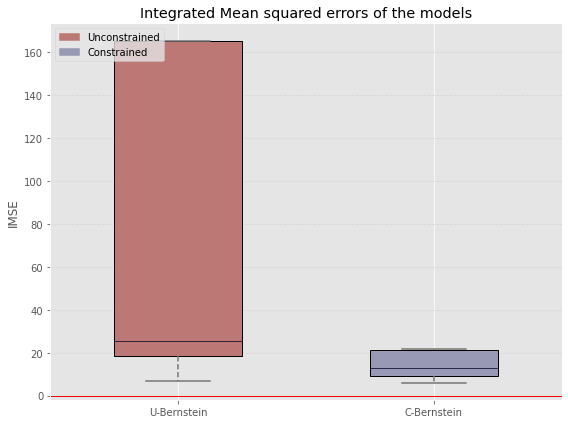

In [150]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Generate random data
np.random.seed(1)


# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Customize boxplot colors
box_colors = ['#BC7874', '#9899B5']
box_labels = ['U-Bernstein', 'C-Bernstein']
legend_labels = ['Unconstrained', 'Constrained']
# Create boxplot
boxplot = ax.boxplot([imse_uncons_normal_crec_ellos*1000, imse_cons_normal_crec_ellos*1000], patch_artist=True, widths=0.5)

# Set boxplot style
for patch, color in zip(boxplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set whisker and cap style
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='#757575', linewidth=1.5, linestyle='--')
    cap.set(color='#757575', linewidth=1.5)

# Set median line style
for median in boxplot['medians']:
    median.set(color='#03052A', linewidth=0.75)

# Set outliers style
for flier in boxplot['fliers']:
    flier.set(marker='o', markersize=5, markerfacecolor='#FF5252', alpha=0.8)

# Create custom legend
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(box_colors, legend_labels)]
legend_patchess = [legend_patches[0], legend_patches[1]]
ax.legend(handles=legend_patchess, loc='upper left')

# Set axis labels and title
ax.set_xticklabels(box_labels)
ax.set_ylabel('IMSE')
ax.set_title('Integrated Mean squared errors of the models')

# Customize grid appearance
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.8)
plt.axhline(0.04695327431427125, color='red', linewidth=1)
# Adjust the plot layout
fig.tight_layout()
plt.box(True)
plt.savefig('normal_inc_imse_ellos.png', transparent=True)

# Show the plot
plt.show()

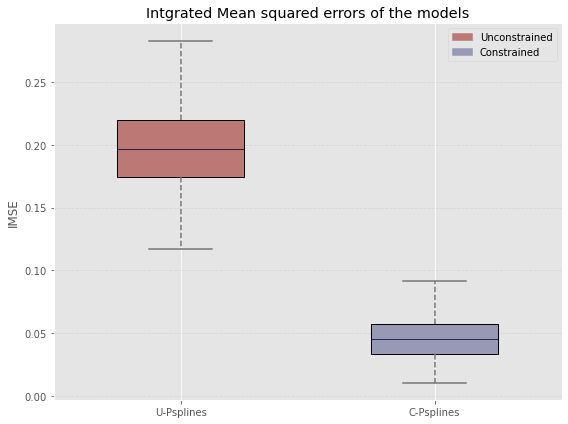

In [148]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Generate random data
np.random.seed(1)


# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Customize boxplot colors
box_colors = ['#BC7874', '#9899B5']
box_labels = ['U-Psplines', 'C-Psplines']
legend_labels = ['Unconstrained', 'Constrained']
# Create boxplot
boxplot = ax.boxplot([IMSE_uncons*1000, IMSE_cons*1000], patch_artist=True, widths=0.5, showfliers=False)

# Set boxplot style
for patch, color in zip(boxplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set whisker and cap style
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='#757575', linewidth=1.5, linestyle='--')
    cap.set(color='#757575', linewidth=1.5)

# Set median line style
for median in boxplot['medians']:
    median.set(color='#03052A', linewidth=0.75)

# Set outliers style
for flier in boxplot['fliers']:
    flier.set(marker='o', markersize=5, markerfacecolor='#FF5252', alpha=0.8)

# Create custom legend
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(box_colors, legend_labels)]
legend_patchess = [legend_patches[0], legend_patches[1]]
ax.legend(handles=legend_patchess, loc='upper right')

# Set axis labels and title
ax.set_xticklabels(box_labels)
ax.set_ylabel('IMSE')
ax.set_title('Intgrated Mean squared errors of the models')

# Customize grid appearance
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.8)

# Adjust the plot layout
fig.tight_layout()
plt.box(True)
plt.savefig('normal_inc_mse_mios.png', transparent=True)
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Generate random data
np.random.seed(1)


# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Customize boxplot colors
box_colors = ['#BC9874', '#9899B5', '#BC9874', '#9899B5']
box_labels = ['U-Psplines', 'C-Psplines', 'U-Bernstein', 'C-Bernstein']
legend_labels = ['Unconstrained', 'Constrained']
# Create boxplot
boxplot = ax.boxplot([MSE_cons*1000, MSE_uncons*1000, mse_uncons_pareto_nonneg_ellos, mse_cons_pareto_nonneg_ellos,], patch_artist=True, widths=0.5)

# Set boxplot style
for patch, color in zip(boxplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set whisker and cap style
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='#757575', linewidth=1.5, linestyle='--')
    cap.set(color='#757575', linewidth=1.5)

# Set median line style
for median in boxplot['medians']:
    median.set(color='#FF5252', linewidth=1)

# Set outliers style
for flier in boxplot['fliers']:
    flier.set(marker='o', markersize=5, markerfacecolor='#FF5252', alpha=0.8)

# Create custom legend
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(box_colors, legend_labels)]
legend_patchess = [legend_patches[0], legend_patches[1]]
ax.legend(handles=legend_patchess, loc='upper left')

# Set axis labels and title
ax.set_xticklabels(box_labels)
ax.set_ylabel('MSE')
ax.set_title('Mean squared errors of the models')

# Customize grid appearance
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.8)

# Adjust the plot layout
fig.tight_layout()
plt.box(True)
plt.savefig('paretitomse.png', transparent=True)
# Show the plot
plt.show()